In [40]:
import pandas as pd
import numpy as np

#using thomas evMutation
from model import CouplingsModel
import tools

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
import scipy

import seaborn as sns

In [41]:
# load parameters from file to create a pairwise model from github.
# assumption: alignment and plmc regularization optimized. need to scan these.
c = CouplingsModel("example/PABP_YEAST.model_params")

(1188, 11) (36522, 10)


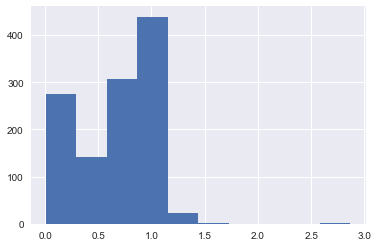

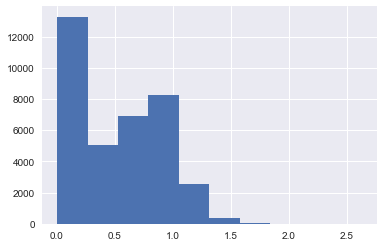

In [110]:
#loading in experimental data
expPath = 'example/experiment/'
singles = pd.read_csv(expPath+'PABP_YEAST_Fields2013-singles/PABP_YEAST_115-210.csv', delimiter=';',comment='#')
doubles = pd.read_csv(expPath+'PABP_YEAST_Fields2013-doubles/PABP_YEAST_125-205.csv', delimiter=';',comment='#')

print(singles.shape, doubles.shape)
singles['linear'].hist()
plt.show()
doubles['XY_Enrichment_score'].hist()
plt.show()

In [111]:
doubles.head()

,mutant,XY_Enrichment_score,effect_class_snap2,effect_score_snap2,effect_class_pph2,effect_score_pph2,effect_conservation_pph2,effect_class_sift,effect_score_sift,effect_score_blosum
0,"G169W,F170V",0.059160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"G169V,F170V",0.045765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"G169A,F170I",0.075799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"G169C,F170Y",0.700485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"G169A,F170S",0.061518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# predict mutations using model
data_pred_singles = tools.predict_mutation_table(
    c, singles, "effect_prediction_epistatic"
)
data_pred_singles = tools.predict_mutation_table(
    c, data_pred_singles, "effect_prediction_independent", hamiltonian='fields'
)

data_pred_doubles  = tools.predict_mutation_table(
    c, doubles, "effect_prediction_epistatic"
)
data_pred_doubles  = tools.predict_mutation_table(
    c, data_pred_doubles, "effect_prediction_independent", hamiltonian='fields'
)


In [124]:
print(data_pred_singles.columns.values)
print(data_pred_doubles.columns.values)

['mutant' 'linear' 'log' 'effect_class_snap2' 'effect_score_snap2'
 'effect_class_pph2' 'effect_score_pph2' 'effect_conservation_pph2'
 'effect_class_sift' 'effect_score_sift' 'effect_score_blosum'
 'effect_prediction_epistatic' 'effect_prediction_independent']
['mutant' 'XY_Enrichment_score' 'effect_class_snap2' 'effect_score_snap2'
 'effect_class_pph2' 'effect_score_pph2' 'effect_conservation_pph2'
 'effect_class_sift' 'effect_score_sift' 'effect_score_blosum' 'mut1K'
 'mut2K' 'effect_prediction_epistatic' 'effect_prediction_independent']


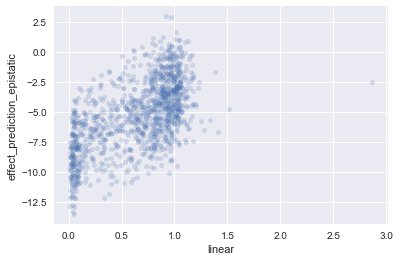

SpearmanrResult(correlation=0.59278057106231807, pvalue=1.2531785515898996e-113)
(0.60184667297711936, 5.6853280713333801e-118)


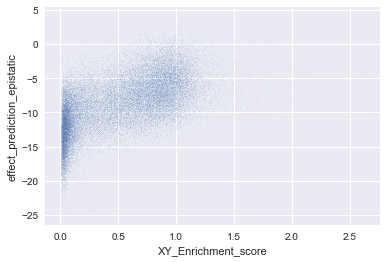

SpearmanrResult(correlation=0.62002180949486574, pvalue=0.0)
(0.60218408721168082, 0.0)


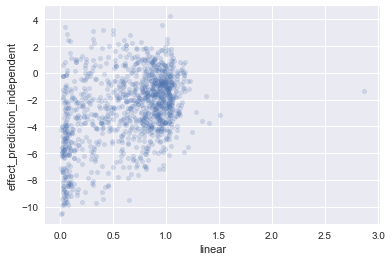

SpearmanrResult(correlation=0.36041804462041666, pvalue=9.3273048552932534e-38)
(0.40909750564117348, 3.8203465784469059e-49)


In [126]:
#sanity check that can get the same correlation as in publication.
data_pred_singles.plot.scatter('linear','effect_prediction_epistatic', alpha=0.2)
plt.show()

print(scipy.stats.spearmanr(data_pred_singles['linear'],data_pred_singles['effect_prediction_epistatic']))
print(scipy.stats.pearsonr(data_pred_singles['linear'],data_pred_singles['effect_prediction_epistatic']))

data_pred_doubles.plot.scatter('XY_Enrichment_score','effect_prediction_epistatic', alpha=0.2, s=0.1)
plt.show()

print(scipy.stats.spearmanr(data_pred_doubles['XY_Enrichment_score'],data_pred_doubles['effect_prediction_epistatic']))
print(scipy.stats.pearsonr(data_pred_doubles['XY_Enrichment_score'],data_pred_doubles['effect_prediction_epistatic']))


#for the independent model
data_pred_singles.plot.scatter('linear','effect_prediction_independent', alpha=0.2)
plt.show()

print(scipy.stats.spearmanr(data_pred_singles['linear'],data_pred_singles['effect_prediction_independent']))
print(scipy.stats.pearsonr(data_pred_singles['linear'],data_pred_singles['effect_prediction_independent']))


In [24]:
#epistasis in the measurements:

In [47]:
#how many double mutant cycles are there?
doubleMutCycles=[]
for k in doubles['mutant']:
    mut1,mut2= k.split(',')
    if mut1 in singles['mutant'].values and mut2 in singles['mutant'].values:
        doubleMutCycles.append(k)
print(len(doubleMutCycles))

36514


In [115]:
#What's distribution of fitness differences of doubles to singles? F(mut1,mut2) - F(mut1) - F(mut2)?

#add mutkeys to doubles df
doubles['mut1K'] = doubles.apply(lambda row: row.mutant.split(',')[0], axis=1)
doubles['mut2K'] = doubles.apply(lambda row: row.mutant.split(',')[1], axis=1)

#merge 2 dataframes together by mutKey
df_merge= doubles.merge(singles[['mutant', 'linear']], left_on='mut1K', right_on='mutant')
df_merge2= df_merge.merge(singles[['mutant','linear']], left_on='mut2K', right_on='mutant')
#print(singles1.loc[singles1['mutant'] =='G169W'])

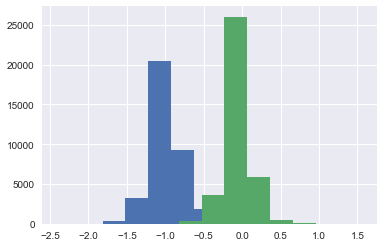

In [116]:
# create column of additive expectation
df_merge2['add_fit_from_linear']=df_merge2.apply(lambda row: row.linear_x+row.linear_y, axis=1)
df_merge2['mult_fit_from_linear']=df_merge2.apply(lambda row: row.linear_x*row.linear_y, axis=1)



#calculate epistasis in experiment
df_merge2['doubleDiffFit_add']=df_merge2.apply(lambda row: row.XY_Enrichment_score-row.add_fit_from_linear, axis=1)
df_merge2['doubleDiffFit_mult']=df_merge2.apply(lambda row: row.XY_Enrichment_score-row.mult_fit_from_linear, axis=1)


df_merge2['doubleDiffFit_add'].hist()
df_merge2['doubleDiffFit_mult'].hist()

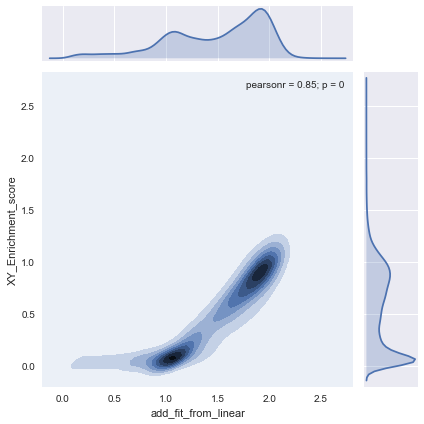

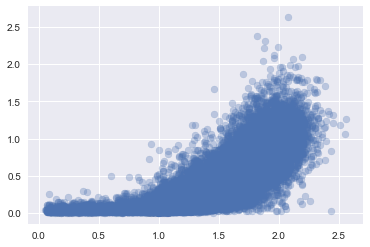

In [52]:
sns.jointplot(x=df_merge2['add_fit_from_linear'], y= df_merge2['XY_Enrichment_score'], kind='kde')
plt.show()
plt.figure()
plt.scatter(df_merge2['add_fit_from_linear'], df_merge2['XY_Enrichment_score'], alpha=0.3)
plt.show()

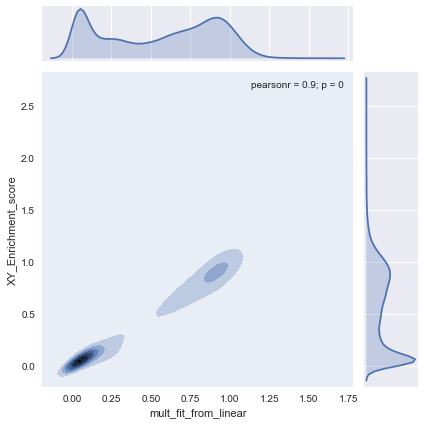

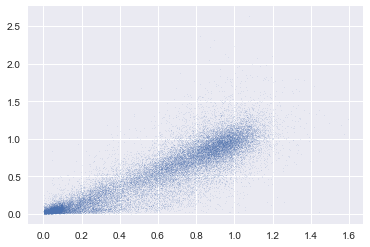

In [53]:
sns.jointplot(x=df_merge2['mult_fit_from_linear'], y= df_merge2['XY_Enrichment_score'], kind='kde')
plt.show()
plt.figure()
plt.scatter(df_merge2['mult_fit_from_linear'], df_merge2['XY_Enrichment_score'], alpha=0.3, s=0.1)
plt.show()

In [60]:
df_merge2.head()


,mutant_x,XY_Enrichment_score,effect_class_snap2,effect_score_snap2,effect_class_pph2,effect_score_pph2,effect_conservation_pph2,effect_class_sift,effect_score_sift,effect_score_blosum,mut1K,mut2K,mutant_y,linear_x,mutant,linear_y,add_fit_from_linear,mult_fit_from_linear,doubleDiffFit_add,doubleDiffFit_mult
0,"G169W,F170V",0.059160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G169W,F170V,G169W,0.049861,F170V,0.041013,0.090874,0.002045,-0.031714,0.057115
1,"G169V,F170V",0.045765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G169V,F170V,G169V,0.044479,F170V,0.041013,0.085492,0.001824,-0.039727,0.043941
2,"G169A,F170V",0.031583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G169A,F170V,G169A,1.044262,F170V,0.041013,1.085275,0.042829,-1.053693,-0.011246
3,"G169R,F170V",0.010790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G169R,F170V,G169R,0.034885,F170V,0.041013,0.075898,0.001431,-0.065108,0.009359
4,"G169E,F170V",0.090777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G169E,F170V,G169E,0.037673,F170V,0.041013,0.078686,0.001545,0.012091,0.089232


In [117]:
data_pred_singles = data_pred_singles[['mutant', 'linear', 'effect_prediction_epistatic']]
data_pred_singles = data_pred_singles.rename(index=str,columns={'linear':'measured_linear_single','effect_prediction_epistatic':'single_pred'})
print(data_pred_singles.head())
data_pred_doubles = data_pred_doubles[['mutant','XY_Enrichment_score','effect_prediction_epistatic']]
data_pred_doubles = data_pred_doubles.rename(index=str,columns={'XY_Enrichment_score':'measured_linear_double','effect_prediction_epistatic':'double_pred'})

print(data_pred_doubles.head())

df_merge2 = df_merge2[['mutant_x','mut1K', 'mut2K', 'mult_fit_from_linear', 'doubleDiffFit_mult']]
df_merge2 = df_merge2.rename(index=str,columns={'doubleDiffFit_mult':'measured_double_diff_fit_mult'})
df_merge2.head()

  mutant  measured_linear_single  single_pred
0  G126A                0.711743    -2.610615
1  G126C                0.449027    -5.663638
2  G126E                0.588928    -6.611062
3  G126D                0.229853    -7.270577
4  G126N                0.679435    -5.809167
        mutant  measured_linear_double  double_pred
0  G169W,F170V                0.059160   -18.161003
1  G169V,F170V                0.045765   -13.753099
2  G169A,F170I                0.075799    -9.115749
3  G169C,F170Y                0.700485    -9.761077
4  G169A,F170S                0.061518   -10.212145


,mutant_x,mut1K,mut2K,mult_fit_from_linear,measured_double_diff_fit_mult
0,"G169W,F170V",G169W,F170V,0.002045,0.057115
1,"G169V,F170V",G169V,F170V,0.001824,0.043941
2,"G169A,F170V",G169A,F170V,0.042829,-0.011246
3,"G169R,F170V",G169R,F170V,0.001431,0.009359
4,"G169E,F170V",G169E,F170V,0.001545,0.089232


In [118]:
#try the predictions
df_merge3= pd.merge(df_merge2, data_pred_doubles, left_on='mutant_x', right_on='mutant', suffixes=('','_double'))
print(df_merge3.head())
#merge in the singles
df_merge4 = pd.merge(df_merge3, data_pred_singles, left_on='mut1K', right_on='mutant',suffixes=('','_s1'))
df_merge5= pd.merge(df_merge4, data_pred_singles, left_on='mut2K', right_on='mutant', suffixes=('','_s2'))


      mutant_x  mut1K  mut2K  mult_fit_from_linear  \
0  G169W,F170V  G169W  F170V              0.002045   
1  G169V,F170V  G169V  F170V              0.001824   
2  G169A,F170V  G169A  F170V              0.042829   
3  G169R,F170V  G169R  F170V              0.001431   
4  G169E,F170V  G169E  F170V              0.001545   

   measured_double_diff_fit_mult       mutant  measured_linear_double  \
0                       0.057115  G169W,F170V                0.059160   
1                       0.043941  G169V,F170V                0.045765   
2                      -0.011246  G169A,F170V                0.031583   
3                       0.009359  G169R,F170V                0.010790   
4                       0.089232  G169E,F170V                0.090777   

   double_pred  
0   -18.161003  
1   -13.753099  
2    -9.130786  
3   -15.980191  
4   -16.540393  


In [119]:
df_merge5['pred_multi_diff'] = df_merge5['double_pred'] - df_merge5['single_pred']* df_merge5['single_pred_s2']
df_merge5['pred_add_diff'] = df_merge5['double_pred'] - df_merge5['single_pred']- df_merge5['single_pred_s2']

In [120]:
df_merge5.head()

,mutant_x,mut1K,mut2K,mult_fit_from_linear,measured_double_diff_fit_mult,mutant,measured_linear_double,double_pred,mutant_s1,measured_linear_single,single_pred,mutant_s2,measured_linear_single_s2,single_pred_s2,pred_multi_diff,pred_add_diff
0,"G169W,F170V",G169W,F170V,0.002045,0.057115,"G169W,F170V",0.059160,-18.161003,G169W,0.049861,-13.490493,F170V,0.041013,-5.12223,-87.262414,0.451720
1,"G169V,F170V",G169V,F170V,0.001824,0.043941,"G169V,F170V",0.045765,-13.753099,G169V,0.044479,-9.499874,F170V,0.041013,-5.12223,-62.413644,0.869006
2,"G169A,F170V",G169A,F170V,0.042829,-0.011246,"G169A,F170V",0.031583,-9.130786,G169A,1.044262,-4.375409,F170V,0.041013,-5.12223,-31.542636,0.366853
3,"G169R,F170V",G169R,F170V,0.001431,0.009359,"G169R,F170V",0.010790,-15.980191,G169R,0.034885,-11.197137,F170V,0.041013,-5.12223,-73.334503,0.339176
4,"G169E,F170V",G169E,F170V,0.001545,0.089232,"G169E,F170V",0.090777,-16.540393,G169E,0.037673,-11.809345,F170V,0.041013,-5.12223,-77.030579,0.391182


(0.15145189966106748, 2.8895501253358321e-186)
SpearmanrResult(correlation=0.1516346882942568, pvalue=1.0250360067090527e-186)


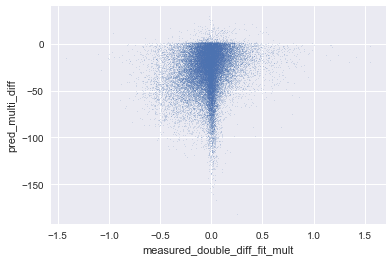

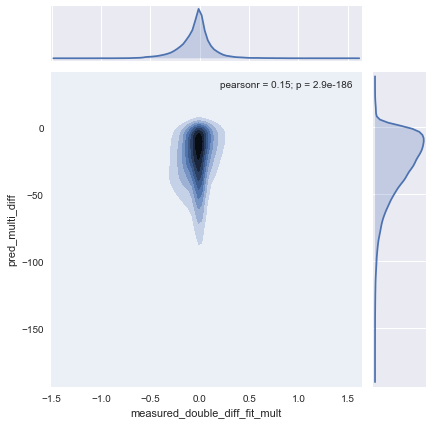

In [121]:
df_merge5.plot.scatter(x='measured_double_diff_fit_mult', y='pred_multi_diff', alpha=0.3, s=0.2)
print(stats.pearsonr(df_merge5['measured_double_diff_fit_mult'], df_merge5['pred_multi_diff']))
print(stats.spearmanr(df_merge5['measured_double_diff_fit_mult'], df_merge5['pred_multi_diff']))

sns.jointplot(df_merge5['measured_double_diff_fit_mult'], df_merge5['pred_multi_diff'],kind='kde')


(0.010765445787795593, 0.039674769414615646)


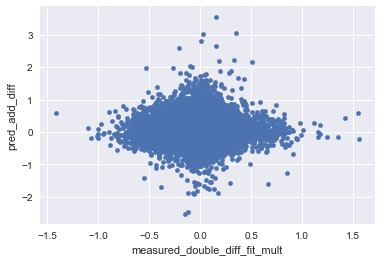

In [122]:
df_merge5.plot.scatter(x='measured_double_diff_fit_mult', y='pred_add_diff')
print(stats.pearsonr(df_merge5['measured_double_diff_fit_mult'], df_merge5['pred_add_diff']))

In [ ]:
#older code right?

In [325]:
def getMutantPred(couplingsObj,mutList):
    #get mutList like [(186, "L", "M"), (188, "G", "A")]
    delta_E, delta_E_couplings, delta_E_fields = couplingsObj.delta_hamiltonian(mutList)
    return delta_E

def returnSingleMutantPrediction_y(row):
    wtAA= row['mutant_y'][0]
    mutAA= row['mutant_y'][-1]
    pos= row['mutant_y'][1:-1]

    try:
        someVar = int(pos)
    except ValueError:
        print(row)
    #print((int(pos), wtAA, mutAA))
    delta_E = getMutantPred(c,[(int(pos), wtAA, mutAA)])
    return delta_E

def returnSingleMutantPrediction_x(row):
    wtAA= row['mutant'][0]
    mutAA= row['mutant'][-1]
    pos= row['mutant'][1:-1]

    delta_E = getMutantPred(c,[(int(pos), wtAA, mutAA)])
    return delta_E

def returnDoubleMutantPrediction(row):
    wtAAx= row['mutant'][0]
    mutAAx= row['mutant'][-1]
    posx= row['mutant'][1:-1]
    
    wtAAy= row['mutant_y'][0]
    mutAAy= row['mutant_y'][-1]
    posy= row['mutant_y'][1:-1]
    
    delta_E = getMutantPred(c,[(int(posy), wtAAy, mutAAy), (int(posx), wtAAx, mutAAx)])
    return delta_E

def diffDoubleMutantPrediction(row):
    return row['doublePred']-row['singlePred_y'] - row['singlePred_x']

def diffDoubleMutantPredictionDivide(row):
    return row['doublePred']/(row['singlePred_y'] * row['singlePred_x'])


df_merge2['singlePred_y'] = df_merge2.apply(returnSingleMutantPrediction_y, axis=1)
df_merge2['singlePred_x'] = df_merge2.apply(returnSingleMutantPrediction_x, axis=1)
df_merge2['doublePred'] = df_merge2.apply(returnDoubleMutantPrediction, axis=1)
df_merge2['doublePredDiff'] = df_merge2.apply(diffDoubleMutantPrediction, axis=1)
df_merge2['doublePredDiffDivide'] = df_merge2.apply(diffDoubleMutantPredictionDivide, axis=1)

SpearmanrResult(correlation=-0.10798819154737725, pvalue=3.849887735846897e-95)


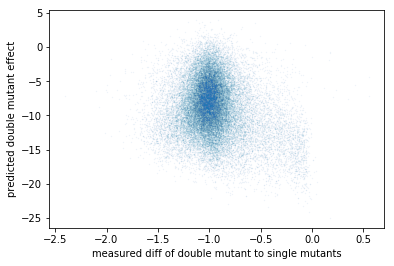

In [326]:
#correlation between epistasis data vs. predicted Fitness of double mutant?
plt.scatter(df_merge2['doubleDiffFit'],df_merge2['doublePred'], alpha=0.1, s=0.1)
plt.xlabel('measured diff of double mutant to single mutants')
plt.ylabel('predicted double mutant effect')
print(scipy.stats.spearmanr(df_merge2['doubleDiffFit'],df_merge2['doublePred']))


SpearmanrResult(correlation=0.046685992735932207, pvalue=4.4321754306085026e-19)


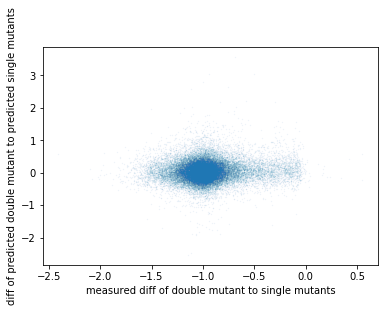

In [237]:
# correlation between the epistasis in data vs predicted difference of double versus predicted fitness of singles?
plt.scatter(df_merge2['doubleDiffFit'],df_merge2['doublePredDiff'], alpha=0.1, s=0.1)
plt.xlabel('measured diff of double mutant to single mutants')
plt.ylabel('diff of predicted double mutant to predicted single mutants')

print(scipy.stats.spearmanr(df_merge2['doubleDiffFit'],df_merge2['doublePredDiff']))


963.660476728 -4499.74435067


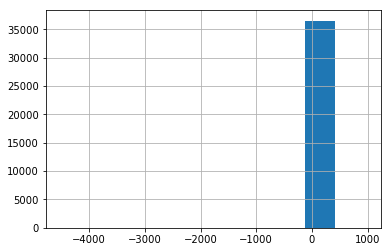

In [245]:
df_merge2['doublePredDiffDivide'].hist()
print(max(df_merge2['doublePredDiffDivide']), min(df_merge2['doublePredDiffDivide']))

SpearmanrResult(correlation=0.098276385492109417, pvalue=4.782368433113928e-79)


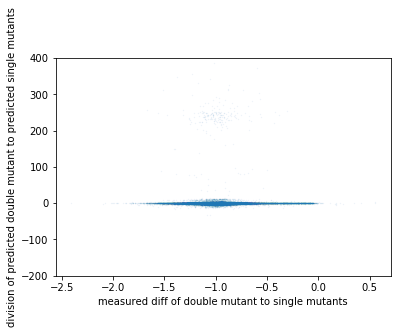

In [247]:
plt.scatter(df_merge2['doubleDiffFit'],df_merge2['doublePredDiffDivide'], alpha=0.1, s=0.1)
plt.ylim([-200,400])
plt.xlabel('measured diff of double mutant to single mutants')
plt.ylabel('division of predicted double mutant to predicted single mutants')


print(scipy.stats.spearmanr(df_merge2['doubleDiffFit'],df_merge2['doublePredDiffDivide']))


In [201]:
#this doesn't work since the delta_E values are negative.
def logDiffDoubleMutantPrediction(row):
    return np.log(row['doublePred'])-np.log(row['singlePred_y']) - np.log(row['singlePred_x'])

df_merge2['logDoublePredDiff'] = df_merge2.apply(logDiffDoubleMutantPrediction, axis=1)

/Users/davidd/anaconda/envs/nn_py34/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


# mean field stuff
 mf model files comes from users/david/orchestra/PABP_march2018/mf/rnabp_mf, and code originally from evCouplings server.

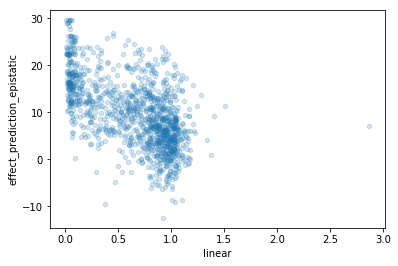

SpearmanrResult(correlation=-0.57445122792573056, pvalue=2.9471092074406437e-105)
(-0.57511113401145209, 1.503637889223052e-105)


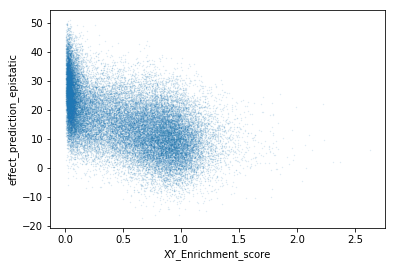

SpearmanrResult(correlation=-0.58850064903245902, pvalue=0.0)
(-0.56977951884478295, 0.0)


In [291]:
#trying the mean field stuff:

c_mf = CouplingsModel("example/mean_field/rnabp.model")
# predict mutations using model
data_pred_singles_mf = tools.predict_mutation_table(
    c_mf, singles, "effect_prediction_epistatic"
)

data_pred_doubles_mf  = tools.predict_mutation_table(
    c_mf, doubles, "effect_prediction_epistatic"
)

#sanity check that can get similarly good prediction
data_pred_singles_mf.plot.scatter('linear','effect_prediction_epistatic', alpha=0.2)
plt.show()

print(scipy.stats.spearmanr(data_pred_singles_mf['linear'],data_pred_singles_mf['effect_prediction_epistatic']))
print(scipy.stats.pearsonr(data_pred_singles_mf['linear'],data_pred_singles_mf['effect_prediction_epistatic']))

data_pred_doubles_mf.plot.scatter('XY_Enrichment_score','effect_prediction_epistatic', alpha=0.2, s=0.1)
plt.show()

print(scipy.stats.spearmanr(data_pred_doubles_mf['XY_Enrichment_score'],data_pred_doubles_mf['effect_prediction_epistatic']))
print(scipy.stats.pearsonr(data_pred_doubles_mf['XY_Enrichment_score'],data_pred_doubles_mf['effect_prediction_epistatic']))


In [389]:
#

count=0
#measured Epistasis

doubleDiffFit = []
predDoubleDiffFit = []

jijs=[]
jijsTriple = []

for i, r in df_merge2.iterrows():
    #print(r['mutant'],r['mut1K'], r['mut2K'])

    
    mut1 = r['mut1K']
    mut2 = r['mut2K']
    #print(mut1,mut2)
    m1_f= getMutantPred(c_mf, [(int(mut1[1:-1]),mut1[0],mut1[-1])])
    m2_f= getMutantPred(c_mf,[(int(mut2[1:-1]),mut2[0],mut2[-1])])
    m1m2_f = getMutantPred(c_mf,[(int(mut1[1:-1]),mut1[0],mut1[-1]),(int(mut2[1:-1]),mut2[0],mut2[-1])])

    jijDouble = c_mf.Jij(int(mut1[1:-1]),int(mut2[1:-1]),mut1[-1],mut2[-1])
    #    print(int(mut1[1:-1]),int(mut2[1:-1]),mut1[1],mut2[-1])
    jijMut1 = c_mf.Jij(int(mut1[1:-1]),int(mut2[1:-1]),mut1[0],mut2[-1]) 
    jijMut2 =c_mf.Jij(int(mut1[1:-1]),int(mut2[1:-1]),mut1[-1],mut2[0])
    
    doubleDiffFit.append(r['doubleDiffFit'])    
    predDoubleDiffFit.append(m1m2_f-m1_f-m2_f)
    jijs.append(jijDouble)
    jijsTriple.append(jijDouble-jijMut1 - jijMut2)




SpearmanrResult(correlation=-0.043948563464447012, pvalue=4.3989933923732292e-17)
SpearmanrResult(correlation=0.14332889891032208, pvalue=7.787766440725481e-167)
SpearmanrResult(correlation=0.48041024485248829, pvalue=0.0)
SpearmanrResult(correlation=0.0034710879912259931, pvalue=0.50716604272040422)
SpearmanrResult(correlation=-0.062657031093976634, pvalue=4.2960999403312546e-33)


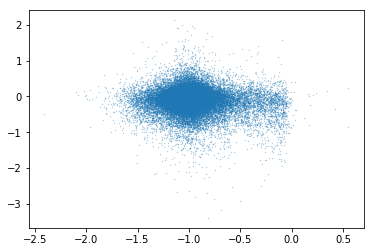

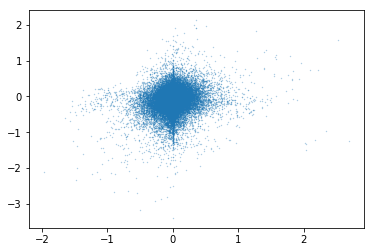

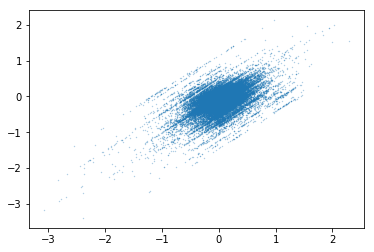

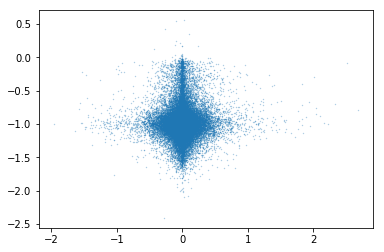

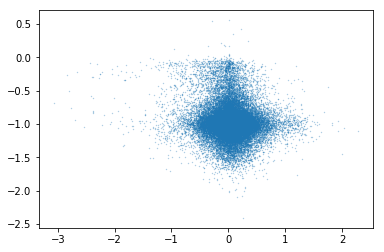

In [390]:
plt.figure()
plt.scatter(doubleDiffFit, predDoubleDiffFit, alpha=0.5, s=0.1)
print(scipy.stats.spearmanr(doubleDiffFit,predDoubleDiffFit))

plt.figure()
plt.scatter(jijs, predDoubleDiffFit, alpha=0.5, s=0.1)
print(scipy.stats.spearmanr(jijs,predDoubleDiffFit))

plt.figure()
plt.scatter(jijsTriple, predDoubleDiffFit, alpha=0.5, s=0.1)
print(scipy.stats.spearmanr(jijsTriple,predDoubleDiffFit))

plt.figure()
plt.scatter(jijs, doubleDiffFit, alpha=0.5, s=0.1)
print(scipy.stats.spearmanr(jijs,doubleDiffFit))

plt.figure()
plt.scatter(jijsTriple, doubleDiffFit, alpha=0.5, s=0.1)
print(scipy.stats.spearmanr(jijsTriple,doubleDiffFit))


In [ ]:
# there should be a correlation between c_mf.jij and the diff in the double mutant prediction???